# Tutorial for analysis of common representation learned by `PICASA` using breast cancer dataset.

Load trained PICASA model file for breast cancer data (see PICASA training tutorial 1).

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import glob
import os

from picasa import model,dutil,util
from scipy.sparse import csr_matrix
import torch
import numpy as np


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



############################
sample = 'brca' 
wdir = '/home/BCCRC.CA/ssubedi/projects/experiments/picasa/picasa_reproducibility/analysis/'+sample

############ read model results as adata 
picasa_adata = ad.read_h5ad(wdir+'/model_results/picasa.h5ad')

#########


Update cell type label to match with paper and add disease subtype label.

In [2]:

cmap = {
'Malignant':'Malignant',
'Mono/Macro':'Monocyte', 
'Plasma':'Plasma',
'Fibroblasts':'Fibroblasts', 
'Endothelial':'Endothelial',
'Tprolif':'T', 
'CD4Tconv':'T', 
'CD8Tex':'T', 
'DC':'DC', 
'Epithelial':'Epithelial', 
'B':'B',
'SMC':'SMC'
}


picasa_adata.obs['celltype']= [cmap[x] for x in picasa_adata.obs['celltype']]

dmap = {
    'CID4495': 'TNBC',
    'CID44971': 'TNBC',
    'CID4471': 'ER+',
    'CID44991': 'TNBC',
    'CID4513': 'TNBC',
    'CID3586': 'HER2+',
    'CID4066': 'HER2+',
    'CID4290A': 'ER+',
    'CID4515': 'TNBC',
    'CID4530N': 'ER+',
    'CID3963': 'TNBC',
    'CID4535': 'ER+',
    'CID4067': 'ER+',
    'CID3921': 'HER2+',
    'CID4398': 'ER+',
    'CID4040': 'ER+',
    'CID45171': 'HER2+',
    'CID3838': 'HER2+',
    'CID44041': 'TNBC',
    'CID3948': 'ER+',
    'CID4523': 'TNBC'
}

picasa_adata.obs['disease']= [dmap[x] for x in picasa_adata.obs['batch']]


Extract all three representation learned by the model.

In [32]:
df = pd.DataFrame(index=picasa_adata.obs.index)

sc.pp.neighbors(picasa_adata,use_rep='common')
sc.tl.umap(picasa_adata)
sc.tl.leiden(picasa_adata)
df[['c_umap1','c_umap2']] = picasa_adata.obsm['X_umap']
df['c_leiden'] = picasa_adata.obs['leiden']

sc.pp.neighbors(picasa_adata,use_rep='unique')
sc.tl.umap(picasa_adata)
sc.tl.leiden(picasa_adata)
df[['u_umap1','u_umap2']] = picasa_adata.obsm['X_umap']
df['u_leiden'] = picasa_adata.obs['leiden']

sc.pp.neighbors(picasa_adata,use_rep='base')
sc.tl.umap(picasa_adata)
sc.tl.leiden(picasa_adata)
df[['b_umap1','b_umap2']] = picasa_adata.obsm['X_umap']
df['b_leiden'] = picasa_adata.obs['leiden']

df['batch']=picasa_adata.obs['batch']
df['celltype']=picasa_adata.obs['celltype']
df['disease']=picasa_adata.obs['disease']


Plot UMAPs based on three representations.

In [33]:

adata = sc.AnnData(df)
adata.obs['batch'] = df['batch'].astype('category')
adata.obs['celltype'] = df['celltype'].astype('category')
adata.obs['disease'] = df['disease'].astype('category')
adata.obs['c_leiden'] = df['c_leiden'].astype('category')
adata.obs['u_leiden'] = df['u_leiden'].astype('category')
adata.obs['b_leiden'] = df['b_leiden'].astype('category')

umap_pairs = [('c_umap1', 'c_umap2'), ('u_umap1', 'u_umap2'), ('b_umap1', 'b_umap2')]



cmap = {
'Malignant':'magenta',
'Monocyte':'green', 
'Fibroblasts':'sienna', 
'Endothelial':'red',
'T':'orange', 
'Plasma':'lightcoral',
'B':'royalblue',
'DC':'lime', 
'SMC':'purple'
}

from picasa.util import palette
color_palette = palette.colors_24

/home/BCCRC.CA/ssubedi/miniconda3/envs/ssubedi/lib/python3.9/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype object


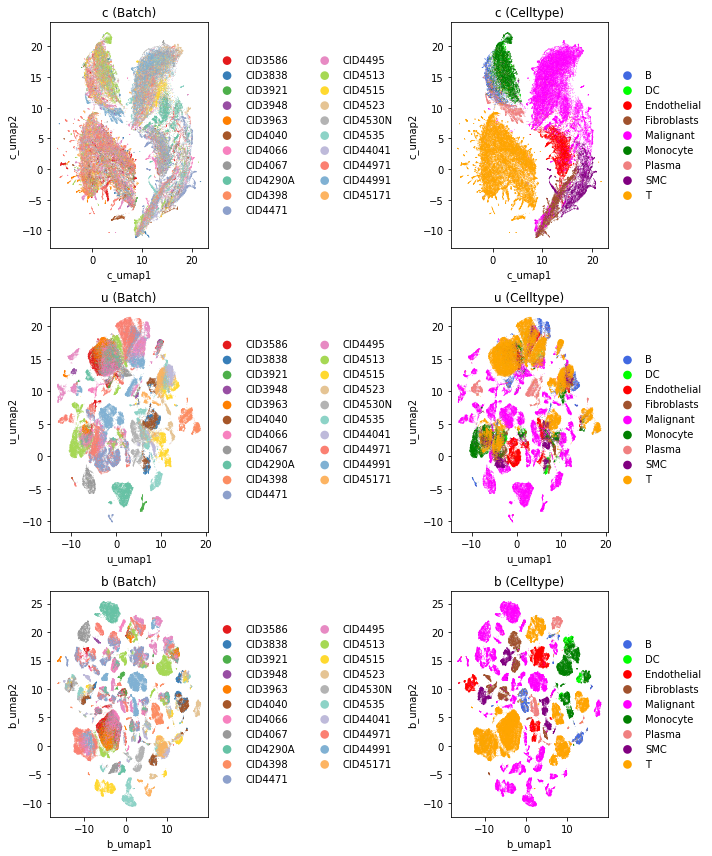

In [34]:

cust_palette = [cmap[label] for label in adata.obs['celltype'].cat.categories]

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, (umap_x, umap_y) in enumerate(umap_pairs):
    sc.pl.scatter(adata, x=umap_x, y=umap_y, color='batch', palette= color_palette,ax=axes[i, 0], show=False)
    axes[i, 0].set_title(f"{umap_x[0]} (Batch)")

    sc.pl.scatter(adata, x=umap_x, y=umap_y,color = 'celltype',palette=cust_palette, ax=axes[i, 1], show=False)
    
    axes[i, 1].set_title(f"{umap_x[0]} (Celltype)")

plt.tight_layout()

Plot with subtype label.

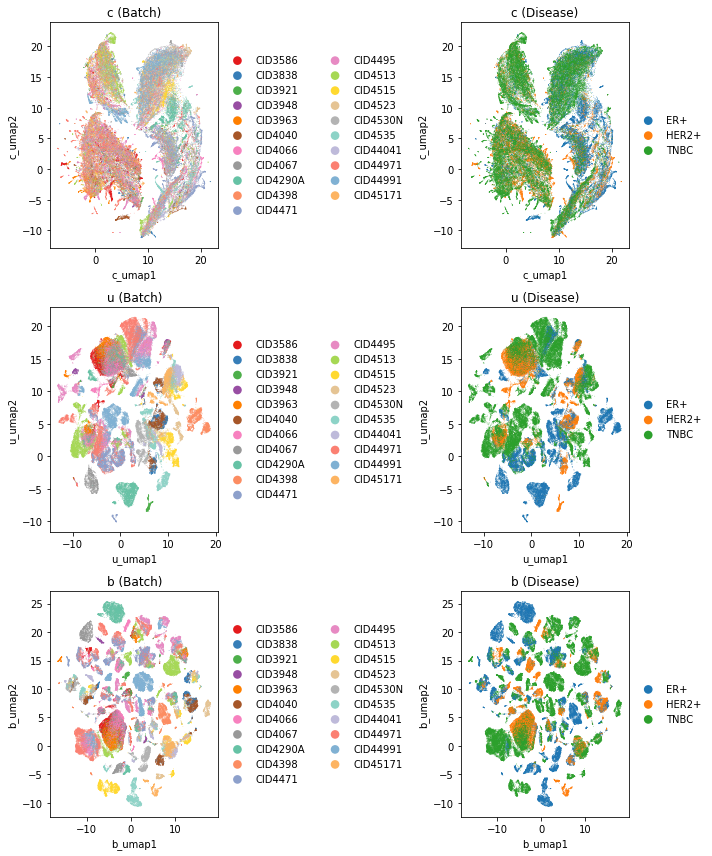

In [35]:

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, (umap_x, umap_y) in enumerate(umap_pairs):
    sc.pl.scatter(adata, x=umap_x, y=umap_y, color='batch', ax=axes[i, 0], show=False)
    axes[i, 0].set_title(f"{umap_x[0]} (Batch)")

    sc.pl.scatter(adata, x=umap_x, y=umap_y, color='disease', ax=axes[i, 1], show=False)
    axes[i, 1].set_title(f"{umap_x[0]} (Disease)")

plt.tight_layout()

Now using leiden clusters based on common representation assign cell type label.

In [36]:

dfleiden = df.copy()
dfg = dfleiden.groupby(['batch','celltype']).count()
dfg = dfleiden.groupby(['c_leiden','celltype']).count()['c_umap1'].reset_index()
celltype_sum = dict(dfg.groupby('c_leiden')['c_umap1'].sum())
dfg['ncount'] = [x/celltype_sum[y] for x,y in zip(dfg['c_umap1'],dfg['c_leiden'])]
dfg.sort_values(['c_leiden','ncount'],ascending=False,inplace=True)

dfg.drop_duplicates(subset='c_leiden',inplace=True)
dfg['p_label'] = ['Common'+str(x)+'/'+y for x,y in zip (dfg['c_leiden'],dfg['celltype'])]

dfg.sort_values(['c_umap1','celltype'],ascending=False,inplace=True)
dfg.drop_duplicates(subset='celltype',inplace=True)


dfleiden['p_label'] = ['Common'+str(x)+'/'+y for x,y in zip (dfleiden['c_leiden'],dfleiden['celltype'])]


dfleiden = dfleiden[dfleiden['p_label'].isin(dfg['p_label'])]
dfleiden['p_label'].value_counts()




/tmp/ipykernel_3059506/3995496939.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_3059506/3995496939.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_3059506/3995496939.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


p_label
Common0/Malignant      5583
Common2/T              4855
Common6/Endothelial    3810
Common5/Monocyte       3299
Common7/Fibroblasts    2886
Common19/SMC           2160
Common12/B             2043
Common21/Plasma        1625
Name: count, dtype: int64

Calculate patient proportion for each cluster.

/tmp/ipykernel_3059506/1885426534.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


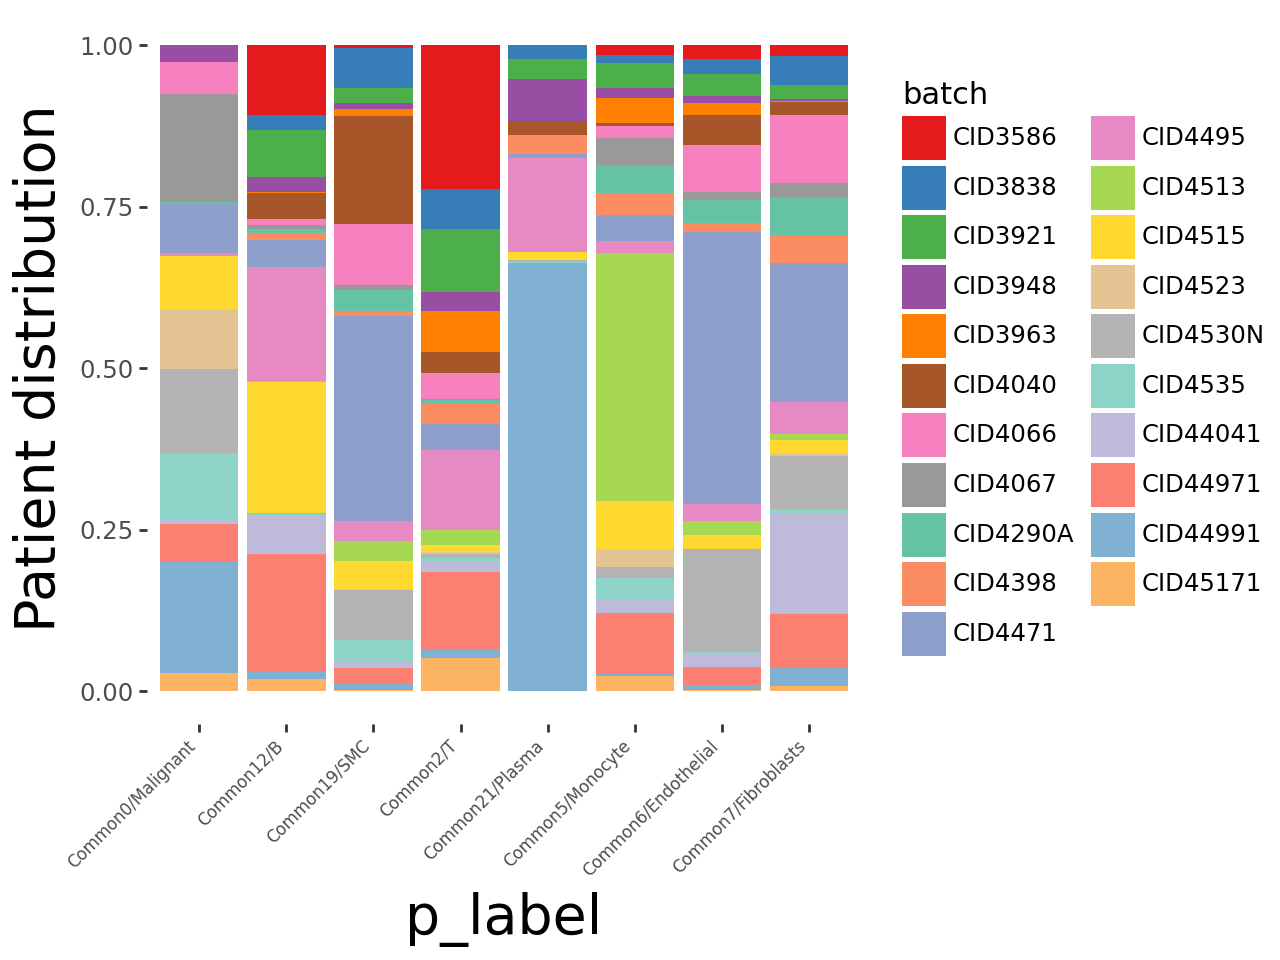

In [37]:

dfg = dfleiden.groupby(['p_label','batch']).count()['c_umap1'].reset_index()
cluster_sum = dict(dfg.groupby('p_label')['c_umap1'].sum())
dfg['ncount'] = [x/cluster_sum[y] for x,y in zip(dfg['c_umap1'],dfg['p_label'])]


nlabel = dfg['p_label'].nunique()
legend_size = 7

p_label_order = dfg['p_label'].unique()

dfg['p_label'] = pd.Categorical(dfg['p_label'], categories=p_label_order, ordered=True)

from picasa.util import palette
from plotnine import *
color_palette = palette.colors_24

p = (ggplot(data=dfg, mapping=aes(x='p_label', fill='batch',weight='ncount')) +
geom_bar(position='stack') +
scale_fill_manual(values=color_palette)  +
labs(x="p_label", y="Patient distribution") +
guides(color=guide_legend(override_aes={'size': legend_size})))

p = p + theme(
    plot_background=element_rect(fill='white'),
    panel_background = element_rect(fill='white'),
    axis_text_x=element_text(rotation=45, hjust=1,size=6),
        axis_title_x=element_text(size=20),
        axis_title_y=element_text(size=20)
)
p

Get expression data for attention matrix analysis.

In [38]:
ddir = '/home/BCCRC.CA/ssubedi/projects/experiments/picasa/picasa_reproducibility/analysis/'+sample+'/model_data/'
pattern = sample+'_*.h5ad'

file_paths = glob.glob(os.path.join(ddir, pattern))
file_names = [os.path.basename(file_path) for file_path in file_paths]

batch_map = {}
batch_count = 0
for file_name in file_names:
	print(file_name)
	batch_map[file_name.replace('.h5ad','').replace(sample+'_','')] = ad.read_h5ad(ddir+file_name)
	batch_count += 1
	if batch_count >=25:
		break

picasa_data = batch_map

brca_CID3963.h5ad
brca_CID4495.h5ad
brca_CID4515.h5ad
brca_CID4040.h5ad
brca_CID4290A.h5ad
brca_CID4067.h5ad
brca_CID44041.h5ad
brca_CID44971.h5ad
brca_CID3948.h5ad
brca_CID4513.h5ad
brca_CID3586.h5ad
brca_CID4471.h5ad
brca_CID4523.h5ad
brca_CID4535.h5ad
brca_CID45171.h5ad
brca_CID4066.h5ad
brca_CID4530N.h5ad
brca_CID4398.h5ad
brca_CID3838.h5ad
brca_CID3921.h5ad
brca_CID44991.h5ad


Get samples of cells from each cluster. Here, each cell will have 2000 x 2000 attention score matrix.

In [39]:
n= 10
dfleiden = dfleiden.groupby(['batch', 'p_label'], group_keys=False).apply(lambda x: x.sample(min(len(x), n)))

p_label_dict = {x.split('@')[0]:y for x,y in zip(dfleiden.index.values,dfleiden['p_label'])}

picasa_data_updated = {}
for d in picasa_data:
	c_cells = dfleiden[dfleiden['batch']==d].index.values
	c_cells = [x.split('@')[0] for x in c_cells]
	
	df_x = picasa_data[d].to_df()
	df_x = df_x.loc[c_cells]
	obs_new = picasa_data[d].obs.loc[c_cells].copy()  
	var_new = picasa_data[d].var.copy()  

	c_adata = ad.AnnData(X=csr_matrix(df_x.values), obs=obs_new, var=var_new)
	c_adata.obs['p_label'] = [p_label_dict[x] for x in c_adata.obs.index.values]
	picasa_data_updated[d] = c_adata
	


/tmp/ipykernel_3059506/2938708249.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_3059506/2938708249.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Get attention matrix for each cell and average it across  cluster/cell type. 

In [43]:
nn_params = picasa_adata.uns['nn_params']
nn_params['device'] = 'cpu'
picasa_common_model = model.PICASACommonNet(nn_params['input_dim'], nn_params['embedding_dim'],nn_params['attention_dim'], nn_params['latent_dim'], nn_params['encoder_layers'], nn_params['projection_layers'],nn_params['corruption_tol'],nn_params['pair_importance_weight']).to(nn_params['device'])
picasa_common_model.load_state_dict(torch.load(wdir+'/model_results/picasa_common.model', map_location=torch.device(nn_params['device'])))


patient_analyzed = []


df = pd.DataFrame()

sel_patients = [
    'CID4515',
    'CID4290A',
    'CID4066'
    ]

for pairs in picasa_adata.uns['adata_pairs']:
	
	p1 = picasa_adata.uns['adata_keys'][pairs[0]]
	p2 = picasa_adata.uns['adata_keys'][pairs[1]]

	if p1 not in patient_analyzed and p1 in sel_patients:
		adata_p1 = picasa_data_updated[p1]
		adata_p2 = picasa_data_updated[p2]
		nbr_map ={}
		nbr_map[p1+'_'+p2] = util.generate_neighbours(adata_p2,adata_p1,p1+p2)
 
		data_loader = dutil.nn_load_data_pairs(adata_p1, adata_p2, nbr_map[p1+'_'+p2],'cpu',batch_size=10)
  
		eval_total_size=adata_p1.shape[0]
		main_attn,main_y = model.eval_attention_common(picasa_common_model,data_loader,eval_total_size)

		##############################################


		unique_celltypes = adata_p1.obs['p_label'].unique()
		num_celltypes = len(unique_celltypes)


		for idx, ct in enumerate(unique_celltypes):
			
			ct_ylabel = adata_p1.obs[adata_p1.obs['p_label'] == ct].index.values
			ct_yindxs = np.where(np.isin(main_y, ct_ylabel))[0]

			min_cells = 1
			if len(ct_yindxs) < min_cells:
				continue

			df_attn = pd.DataFrame(np.mean(main_attn[ct_yindxs], axis=0),
								index=adata_p1.var.index.values, columns=adata_p1.var.index.values)
			np.fill_diagonal(df_attn.values, 0)
			df_attn.index = [p1+'@'+ct+'_'+x for x in df_attn.index]
			df = pd.concat([df, df_attn], axis=0)
			print(p1,ct,len(ct_yindxs),df.shape)
			patient_analyzed.append(p1)
	

/tmp/ipykernel_3059506/2984190890.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


CID4515 Common0/Malignant 10 (2037, 2037)
CID4515 Common12/B 10 (4074, 2037)
CID4515 Common19/SMC 10 (6111, 2037)
CID4515 Common2/T 10 (8148, 2037)
CID4515 Common21/Plasma 10 (10185, 2037)
CID4515 Common5/Monocyte 10 (12222, 2037)
CID4515 Common6/Endothelial 10 (14259, 2037)
CID4515 Common7/Fibroblasts 10 (16296, 2037)
CID4290A Common0/Malignant 5 (18333, 2037)
CID4290A Common12/B 10 (20370, 2037)
CID4290A Common19/SMC 10 (22407, 2037)
CID4290A Common2/T 10 (24444, 2037)
CID4290A Common5/Monocyte 10 (26481, 2037)
CID4290A Common6/Endothelial 10 (28518, 2037)
CID4290A Common7/Fibroblasts 10 (30555, 2037)
CID4066 Common0/Malignant 10 (32592, 2037)
CID4066 Common12/B 10 (34629, 2037)
CID4066 Common19/SMC 10 (36666, 2037)
CID4066 Common2/T 10 (38703, 2037)
CID4066 Common5/Monocyte 10 (40740, 2037)
CID4066 Common6/Endothelial 10 (42777, 2037)
CID4066 Common7/Fibroblasts 10 (44814, 2037)


Check activity of cell type marker genes in each clusters.

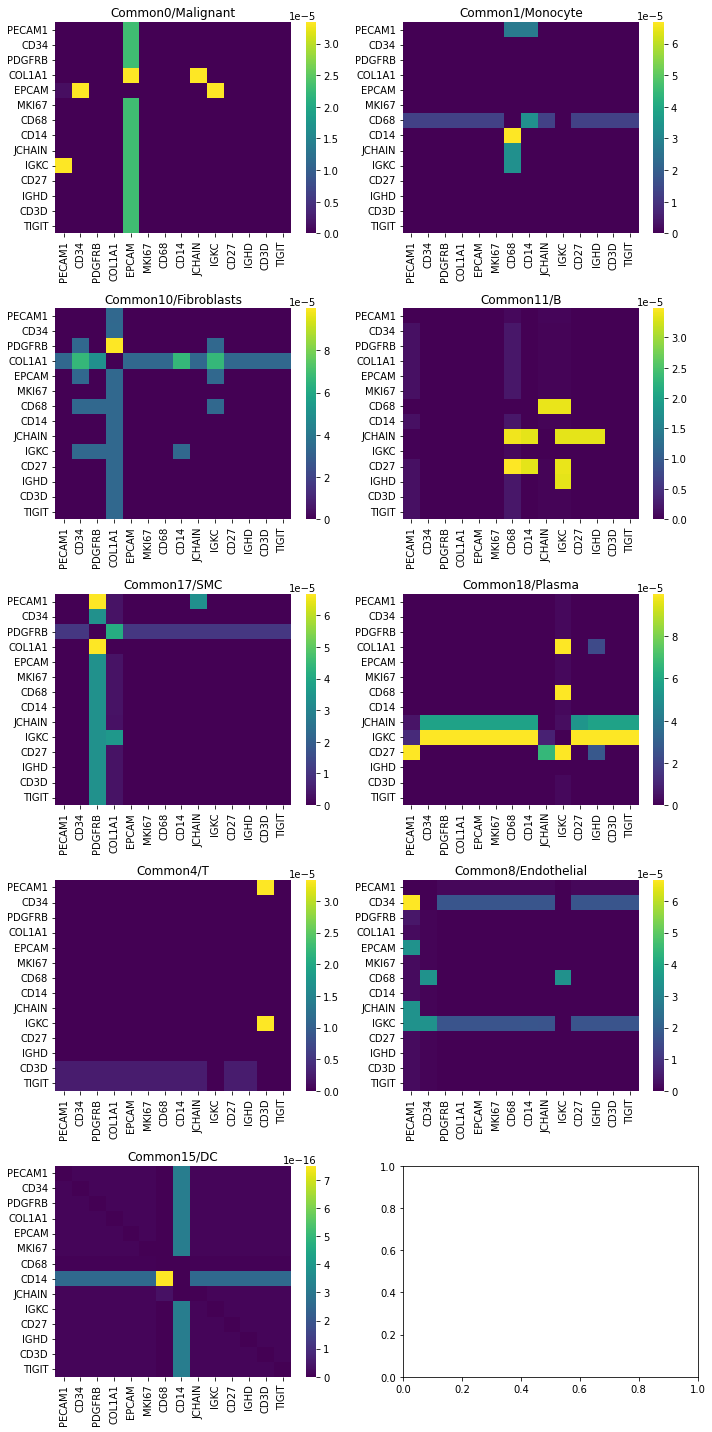

In [5]:

dfl = pd.DataFrame(df.index.values)
dfl['patient'] = [x.split('@')[0] for x in dfl[0]]
dfl['celltype'] = [x.split('@')[1].split('_')[0] for x in dfl[0]]
dfl['gene'] = [x.split('_')[1] for x in dfl[0]]
dfl.drop(0,axis=1,inplace=True)
dfl.reset_index(inplace=True)


######## cell type markers


marker = [
    'PECAM1','CD34', 
    'PDGFRB', 'COL1A1', 
    'EPCAM', 'MKI67', 
    'CD68','CD14', 
    'JCHAIN','IGKC',
    'CD27','IGHD',
    'CD3D', 'TIGIT'  
]
    
unique_celltypes = dfl['celltype'].unique()

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for idx, ct in enumerate(unique_celltypes):
    
    row, col = idx // 2, idx % 2
    
    ct_ylabel = dfl[dfl['celltype'] == ct].index.values
    df_attn = df.iloc[ct_ylabel,:].copy()
    
    df_attn[df_attn > np.float32(0.0001)] = np.float32(0.0001)

    sel_genes = [x for x in marker if x in df_attn.columns]
    df_attn = df_attn.loc[:,sel_genes]
    
    df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
    df_attn = df_attn[df_attn['gene'].isin(sel_genes)]
    df_attn = df_attn.groupby('gene').mean()
    
    df_attn = df_attn.loc[sel_genes,sel_genes]
    
    df_attn.columns = [x.split('-')[0] for x in df_attn.columns]
    df_attn.index = [x.split('-')[0] for x in df_attn.index]
    sns.heatmap(df_attn, ax=axes[row, col],
                yticklabels=df_attn.index,  
                xticklabels=df_attn.columns,  
                cmap='viridis' 
                )
    axes[row, col].set_title(ct)
    
plt.tight_layout()

Run gene set enrichment analysis using PanglaoDB_Augmented_2021.

Running GSEA for PanglaoDB_Augmented_2021


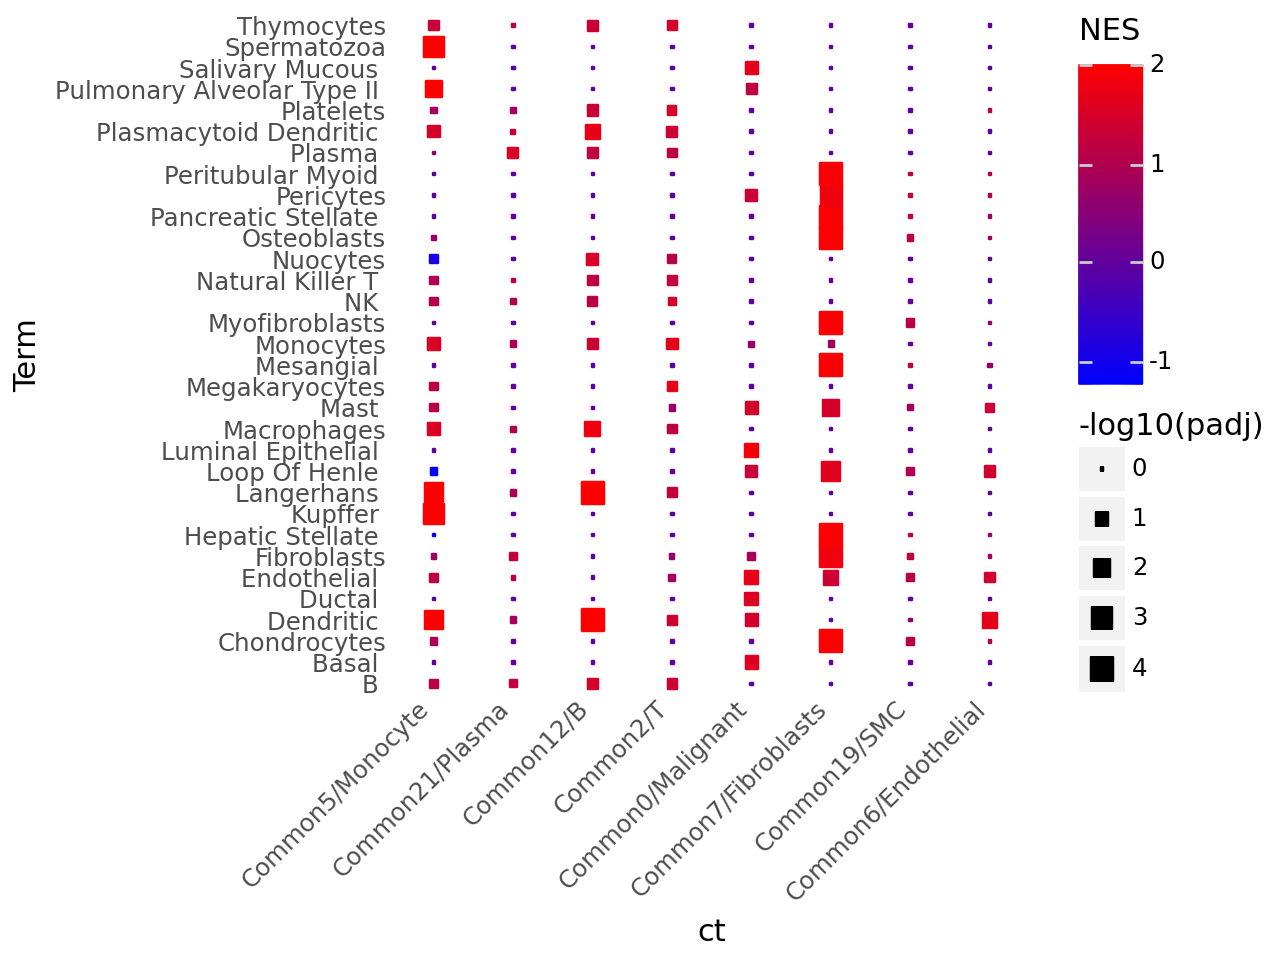

In [48]:


ranked_gene_list = {}
top_n = 2000 ## this is ok as total gene is 2k so all ranked
for idx, ct in enumerate(unique_celltypes):
	ct_ylabel = dfl[dfl['celltype'] == ct].index.values
	df_attn = df.iloc[ct_ylabel,:].copy()
	
	df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
	df_attn = df_attn.groupby('gene').mean()
 
	df_attn = df_attn.unstack().reset_index()

	df_attn.columns = ['Gene1','Gene2','Score']
	df_attn = df_attn.sort_values('Score',ascending=False)
 
	df_attn = df_attn.iloc[:top_n,:]

	df_attn = pd.melt(df_attn, 
					id_vars=['Score'], 
					value_vars=['Gene1', 'Gene2'], 
					var_name='Gene_Type', 
					value_name='Gene')

	df_attn = df_attn[['Gene','Score']]
	df_attn = df_attn.drop_duplicates(subset='Gene') 
	df_attn['Score'] = df_attn['Score'] + (0.1*(df_attn.index.values[::-1]))
	df_attn['Gene'] = df_attn['Gene'].str.upper()
	ranked_gene_list[ct] = df_attn.reset_index(drop=True)
	

import gseapy as gp
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from plotnine import *
pd.set_option('future.no_silent_downcasting', True)

available_libraries = gp.get_library_name(organism="Human")

dbs = [
	'PanglaoDB_Augmented_2021' 
	]

pval_col = 'FDR q-val' 
nes_col = 'NES'  
min_size, max_size = 10, 500  
top_n_pathways = 5

all_pathway_results = {}

for db in dbs:
		print(f"Running GSEA for {db}")
		gene_set_library = gp.get_library(name=db, organism="Human")

		all_pathways = []

		for factor in unique_celltypes:
			gsea_res = gp.prerank(
				rnk=ranked_gene_list[factor],
				gene_sets=gene_set_library,
				min_size=min_size,
				max_size=max_size,
				permutation_num=1000,
				outdir=None,
			)

			all_pathway_results[factor] = gsea_res.res2d

			top_paths = (
				gsea_res.res2d.sort_values(by=nes_col, ascending=False)
				.head(top_n_pathways)["Term"]
				.values
			)
			all_pathways.extend(top_paths)

		selected_pathways = np.unique(all_pathways)

		df_result = pd.DataFrame()

		for factor in unique_celltypes:
			df_gsea = all_pathway_results[factor].set_index("Term")

			df_gsea = df_gsea.reindex(selected_pathways)
			## 1 for pval	
			df_gsea[pval_col] = df_gsea[pval_col].fillna(1.0)
			## 0 for nes
			df_gsea[nes_col] = df_gsea[nes_col].fillna(0.0)

			df_gsea["ct"] = factor
			df_result = pd.concat([df_result, df_gsea], axis=0)

		df_result[pval_col] = pd.to_numeric(df_result[pval_col], errors='coerce')
		df_result[nes_col] = pd.to_numeric(df_result[nes_col], errors='coerce')
		pval_col_log = '-log10(padj)'
		df_result[pval_col_log] = -np.log10(df_result[pval_col]+1e-8)
		df_result[pval_col_log] = df_result[pval_col_log].clip(lower=0, upper=4)
		df_result[nes_col] = df_result[nes_col].clip(lower=-2, upper=2)
  
  
  
		df_result.reset_index(inplace=True)
		df_result = df_result[[pval_col_log, nes_col,"Term","ct"]]
		pivot_df = df_result.pivot(index="Term", columns="ct", values=nes_col)
		row_linkage = linkage(pivot_df, method="ward")
		col_linkage = linkage(pivot_df.T, method="ward")
		row_order = leaves_list(row_linkage)
		col_order = leaves_list(col_linkage)
  
		df_result["Term"] = pd.Categorical(df_result["Term"], categories=pivot_df.index[row_order], ordered=True)
		df_result["ct"] = pd.Categorical(df_result["ct"], categories=pivot_df.columns[col_order], ordered=True)


		df_result['Term'] = [x.replace('Cells','') for x in df_result['Term']]		
		##save before plot
  
		p = (ggplot(df_result, aes(x='ct', y='Term', color='NES', size=pval_col_log)) 
				# + geom_point()
				+ geom_point(shape='s')
				+ scale_color_gradient(low="blue", high="red")
				+ scale_size_continuous(range=(0, 4))
				+ theme(panel_grid=element_blank(),  
						panel_background=element_blank(),
						axis_line=element_blank(),  
						axis_ticks=element_blank(),  
						axis_text_x=element_text(rotation=45, hjust=1),
						plot_background=element_rect(fill='white', color='white',
						)  
						)  
		)
p 